In [4]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np


# Load the dataset
data = pd.read_csv('jobs-usa-linkedin.csv')


RecursionError: maximum recursion depth exceeded while calling a Python object

In [19]:
# Select the relevant column (date)
data = data[['posted_date']]

# Convert 'posted_date' to datetime objects
data['posted_date'] = pd.to_datetime(data['posted_date'])

# Sort data by date
data = data.sort_values('posted_date')

# Create a numerical representation of the dates (days since a reference date)
reference_date = data['posted_date'].min()
data['days_since'] = (data['posted_date'] - reference_date).dt.days

# Check for NaN values in 'days_since'
print("NaN values in 'days_since':", data['days_since'].isnull().sum())

# Drop rows with NaN values in 'days_since'
data = data.dropna(subset=['days_since'])

# Use only the 'days_since' column for prediction
date_data = data['days_since'].values.reshape(-1, 1)

# Check for NaN values
print("NaN values in date_data before scaling:", np.isnan(date_data).sum())

# Normalize date data
scaler = MinMaxScaler(feature_range=(0, 1))
date_data = scaler.fit_transform(date_data)

# Check for NaN values after scaling
print("NaN values in date_data after scaling:", np.isnan(date_data).sum())

# If there are any NaN values after scaling, they need to be removed
nan_indices = np.isnan(date_data).flatten()
date_data = date_data[~nan_indices]

print("NaN values removed. New shape of date_data:", date_data.shape)


NaN values in 'days_since': 2845
NaN values in date_data before scaling: 0
NaN values in date_data after scaling: 0
NaN values removed. New shape of date_data: (2845, 1)


In [20]:
# Prepare data for LSTM (create sequences)
from copy import copy
look_back = 30  # Number of previous days to consider
X, Y = [], []
for i in range(look_back, len(date_data)):
    X.append(date_data[i - look_back:i])
    Y.append(date_data[i])

X = np.array(X)
Y = np.array(Y)

# Check for NaN values in X and Y
print("NaN values in X:", np.isnan(X).sum())
print("NaN values in Y:", np.isnan(Y).sum())
X_train = copy(X)
Y_train = copy(Y)
X_test = copy(X)
Y_test = copy(Y)



NaN values in X: 0
NaN values in Y: 0


In [21]:

# Create the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dense(1)
])

# Use a smaller learning rate to check for numerical stability
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Train the model
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test))

# Save the model
model.save('lstm_date_prediction_model.h5')

# Plot the loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


Epoch 1/100


d:\Backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.1289 - val_loss: 5.0521e-04
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 4.5275e-04 - val_loss: 2.7767e-04
Epoch 3/100
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.1928e-04

KeyboardInterrupt: 

88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


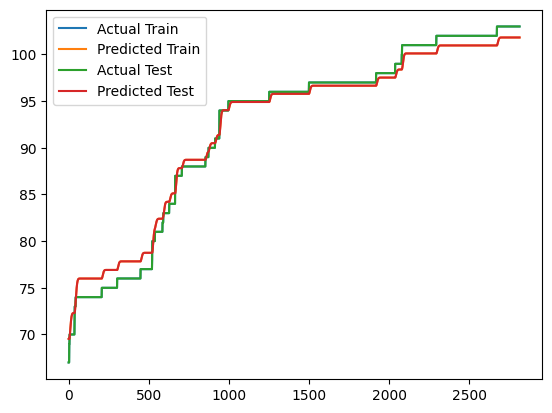

In [22]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions to get actual date values
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))  # Reshape to 2D array
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D array

# Plot training and test predictions
plt.plot(Y_train, label='Actual Train')
plt.plot(train_predict, label='Predicted Train')
plt.plot(Y_test, label='Actual Test')
plt.plot(test_predict, label='Predicted Test')
plt.legend()
plt.show()


In [23]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('lstm_date_prediction_model.h5')

# Recompile the model with the same loss and optimizer
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

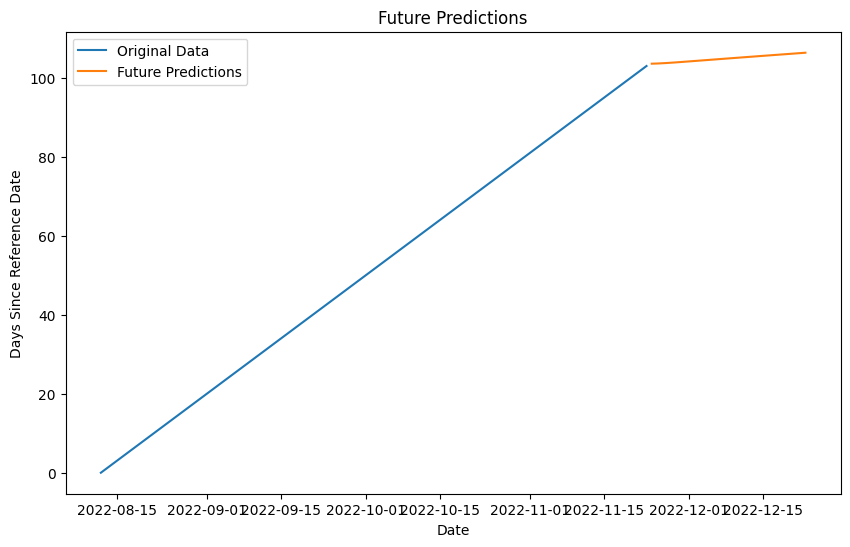

In [24]:
# Predict the next 30 days
future_days = 30
look_back = 30  # This should match the look_back value used during training
last_sequence = date_data[-look_back:]  # Get the last sequence to predict the next day

future_predictions = []
for _ in range(future_days):
    next_prediction = model.predict(last_sequence.reshape(1, look_back, 1))
    future_predictions.append(next_prediction[0, 0])
    # Update the last sequence with the new prediction
    last_sequence = np.append(last_sequence[1:], next_prediction)

# Invert the predictions to get actual date values
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = scaler.inverse_transform(future_predictions)

# Generate future dates
last_date = data['posted_date'].max()
future_dates = pd.date_range(last_date, periods=future_days + 1, inclusive='right')
print(future_dates)
print(future_predictions)

# Plot the future predictions
plt.figure(figsize=(10, 6))
plt.plot(data['posted_date'], data['days_since'], label='Original Data')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Days Since Reference Date')
plt.title('Future Predictions')
plt.show()


In [30]:

import pickle

with open('posted_date.pkl', 'rb') as file:
    loaded_posted = pickle.load(file)

print("Original data:", data['posted_date'])
print("Loaded data:", loaded_posted)




Original data: 4689   2022-08-12
4673   2022-10-04
4671   2022-10-13
4811   2022-10-18
4711   2022-10-18
          ...    
885    2022-11-23
3789   2022-11-23
3777   2022-11-23
925    2022-11-23
2981   2022-11-23
Name: posted_date, Length: 2845, dtype: datetime64[ns]
Loaded data: 4689   2022-08-12
4673   2022-10-04
4671   2022-10-13
4811   2022-10-18
4711   2022-10-18
          ...    
885    2022-11-23
3789   2022-11-23
3777   2022-11-23
925    2022-11-23
2981   2022-11-23
Name: posted_date, Length: 2845, dtype: datetime64[ns]


In [28]:
data['posted_date']


4689   2022-08-12
4673   2022-10-04
4671   2022-10-13
4811   2022-10-18
4711   2022-10-18
          ...    
885    2022-11-23
3789   2022-11-23
3777   2022-11-23
925    2022-11-23
2981   2022-11-23
Name: posted_date, Length: 2845, dtype: datetime64[ns]